<a href="https://colab.research.google.com/github/Haripraveen-Chenna/Diabetes_Readmission/blob/main/diabetes_readmission_xgb_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Dependencies

> **Readme:**
> This cell installs the required Python libraries (`xgboost`, `joblib`, `imbalanced-learn`) for the notebook.

In [9]:
!pip install -q xgboost==1.7.6 shap joblib imbalanced-learn==0.11.0

## 2. Imports and Global Setup

> **Readme:**
> This cell imports all necessary libraries (like `pandas`, `numpy`, `sklearn`) and sets up global variables, like the random seed (`RSEED`) and a save directory (`SAVE_DIR`).

In [10]:
import os, json, random, warnings
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    f1_score, confusion_matrix, precision_recall_curve,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

warnings.filterwarnings("ignore")
RSEED = 42
np.random.seed(RSEED)
random.seed(RSEED)

SAVE_DIR = "/content/ml_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

## 3. Load Data

> **Readme:**
> This cell loads the `diabetic_data.csv` file into a pandas DataFrame.


In [11]:
DATA_PATH = "/content/diabetic_data.csv"

df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)

Raw shape: (101766, 50)


## 4. Target Variable Cleaning

> **Readme:**
> This cell cleans the target variable `readmitted`. It maps `>30` and `NO` to `0` (not readmitted) and `<30` to `1` (readmitted). It also drops ID columns.

In [12]:
df = df.replace("?", np.nan)
df["readmitted"] = df["readmitted"].replace({">30":0, "<30":1, "NO":0}).astype(int)

for c in ["encounter_id", "patient_nbr"]:
    df = df.drop(columns=c, errors="ignore")

## 5. Feature Engineering (Helper Functions)

> **Readme:**
> This cell defines two helper functions. `map_icd` groups diagnosis codes into broader categories (e.g., 'circulatory'), and `age_num` converts age ranges (like `[70-80)`) into a single number (like `75`).

In [13]:
def map_icd(code):
    if pd.isna(code): return "unknown"
    c = str(code).split('.')[0]
    try: i = int(c)
    except: return "other"
    if 1<=i<=139: return "infectious"
    if 140<=i<=239: return "neoplasm"
    if 240<=i<=279: return "endocrine"
    if 280<=i<=289: return "blood"
    if 290<=i<=319: return "mental"
    if 320<=i<=389: return "nervous"
    if 390<=i<=459: return "circulatory"
    if 460<=i<=519: return "respiratory"
    if 520<=i<=579: return "digestive"
    if 580<=i<=629: return "genitourinary"
    if 630<=i<=679: return "pregnancy"
    if 680<=i<=709: return "skin"
    if 710<=i<=739: return "musculoskeletal"
    if 740<=i<=759: return "congenital"
    if 760<=i<=779: return "perinatal"
    if 780<=i<=799: return "symptoms"
    if 800<=i<=999: return "injury_poison"
    return "other"

def age_num(x):
    bins = {'[0-10)':5,'[10-20)':15,'[20-30)':25,'[30-40)':35,'[40-50)':45,'[50-60)':55,
            '[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95}
    return bins.get(str(x), 50)

## 6. Feature Engineering (Apply Logic)

> **Readme:**
> This cell applies the functions from the last cell to create new features. This includes grouping diagnoses, creating binary flags (like `insulin_flag`), and building simple risk scores (`comorbidity_score`).

In [14]:
work = df.copy()

for d in ["diag_1","diag_2","diag_3"]:
    if d in work:
        work[f"{d}_group"] = work[d].astype(str).apply(map_icd)
        work.drop(columns=d, inplace=True, errors="ignore")

work['age_num'] = work['age'].apply(age_num)

nums = ["number_outpatient","number_emergency","number_inpatient",
        "num_medications","number_diagnoses","time_in_hospital"]
for c in nums:
    if c in work: work[c] = pd.to_numeric(work[c], errors="coerce").fillna(0).astype(int)

if all(c in work for c in ["number_outpatient","number_emergency","number_inpatient"]):
    work["total_visits"] = work["number_outpatient"] + work["number_emergency"] + work["number_inpatient"]

if "insulin" in work: work["insulin_flag"] = (work["insulin"].astype(str).str.lower()!="no").astype(int)
if "diabetesMed" in work: work["diabetes_med_flag"] = (work["diabetesMed"].astype(str)=="Yes").astype(int)
if "change" in work: work["change_flag"] = (work["change"].astype(str)=="Ch").astype(int)

if "time_in_hospital" in work and "number_diagnoses" in work:
    work["severity_index"] = work["time_in_hospital"]*(work["number_diagnoses"]+1)

work["comorbidity_score"] = 0
if "num_medications" in work: work["comorbidity_score"] += (work["num_medications"]>10).astype(int)
if "number_diagnoses" in work: work["comorbidity_score"] += (work["number_diagnoses"]>8).astype(int)
if "time_in_hospital" in work: work["comorbidity_score"] += (work["time_in_hospital"]>6).astype(int)
work["comorbidity_score"] += (work["age_num"]>=75).astype(int)

print("Engineered shape:", work.shape)

Engineered shape: (101766, 55)


## 7. Feature Selection and Encoding

> **Readme:**
> This cell prepares the data for modeling. It selects the final features, converts categorical columns (like 'gender') into numbers using `LabelEncoder`, and fills any missing numeric values with the median.

In [15]:
TARGET = "readmitted"
X = work.drop(columns=[TARGET])
y = work[TARGET]

selected = []
for c in X.columns:
    if X[c].dtype.kind in "biufc": selected.append(c)
    else:
        if X[c].nunique() <= 200: selected.append(c)

X = X[selected]

cat_cols = X.select_dtypes(include=["object"]).columns
le_map = {}
for c in cat_cols:
    X[c] = X[c].astype(str).fillna("missing")
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    le_map[c] = le

for c in X.columns:
    if c not in cat_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())

## 8. Split Data (Train, Validation, Test)

> **Readme:**
> This cell splits the data into three sets: a **training set** (to build the model), a **validation set** (to tune the model), and a **test set** (to get the final, unbiased score). `stratify=y` ensures all sets have a similar mix of readmitted patients.

In [16]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RSEED, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=RSEED, stratify=y_trainval)

print("Train shape:", X_train.shape, "| Val shape:", X_val.shape, "| Test shape:", X_test.shape)

Train shape: (65129, 54) | Val shape: (16283, 54) | Test shape: (20354, 54)


## 9. Easy-Ensemble: Setup

> **Readme:**
> This cell sets up the Easy-Ensemble model. Because the data is imbalanced (few 'readmitted' patients), we split the training data into 'minority' (class `1`) and 'majority' (class `0`) groups.

In [17]:
N_MODELS = 12
models = []
val_probs_list = []

xgb_params = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": RSEED,
}

train_df = X_train.copy()
train_df["__y"] = y_train

minor = train_df[train_df["__y"]==1]
major = train_df[train_df["__y"]==0]

print(f"Dataset Imbalance: Minority class (1) has {len(minor)} samples. Majority (0) has {len(major)} samples.")

Dataset Imbalance: Minority class (1) has 7269 samples. Majority (0) has 57860 samples.


## 10. Easy-Ensemble: Training Loop

> **Readme:**
> This is the main training loop. It trains `N_MODELS` (12) separate XGBoost models. Each model is trained on a **balanced** dataset containing all the minority samples and a random sample of the majority samples. The final prediction will be an average of all 12 models.

In [18]:
for i in range(N_MODELS):
    print(f"Training model {i+1}/{N_MODELS}...")

    maj_sample = resample(major,
                          replace=False,
                          n_samples=len(minor),
                          random_state=RSEED+i)

    batch = pd.concat([minor, maj_sample]).sample(frac=1.0, random_state=RSEED+i)

    y_tr = batch["__y"].values
    X_tr = batch.drop(columns="__y")

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr)
    models.append(model)

    val_probs_list.append(model.predict_proba(X_val)[:,1])

print(f"\nSuccessfully trained {len(models)} models.")

Training model 1/12...
Training model 2/12...
Training model 3/12...
Training model 4/12...
Training model 5/12...
Training model 6/12...
Training model 7/12...
Training model 8/12...
Training model 9/12...
Training model 10/12...
Training model 11/12...
Training model 12/12...

Successfully trained 12 models.


## 11. Model Calibration

> **Readme:**
> This cell averages the predictions from all 12 models. Then, it uses a `LogisticRegression` model to 'calibrate' these averaged probabilities, making them more reliable. Finally, it calculates the test set's `ROC-AUC` and `PR-AUC` scores.

In [19]:
val_avg = np.mean(val_probs_list, axis=0)

calibrator = LogisticRegression()
calibrator.fit(val_avg.reshape(-1,1), y_val)

test_model_probs = np.mean([m.predict_proba(X_test)[:,1] for m in models], axis=0)

test_cal = calibrator.predict_proba(test_model_probs.reshape(-1,1))[:,1]

print("Test ROC-AUC:", roc_auc_score(y_test, test_cal))
print("Test PR-AUC (AUPRC):", average_precision_score(y_test, test_cal))

Test ROC-AUC: 0.6876185531596283
Test PR-AUC (AUPRC): 0.23720801445885162


## 12. Threshold Tuning and Classification Report

> **Readme:**
> This cell finds the best probability threshold for making a prediction. Instead of the default 0.5, it searches for the threshold (e.g., 0.35) that gives the best **F1-Score** on the validation set. It then uses this best threshold to generate a final classification report for the test set.

In [20]:
def tune_threshold(probs, y, low=0.01, high=0.8, steps=200):
    best_t, best_f = 0.5, -1
    for t in np.linspace(low, high, steps):
        pred = (probs >= t).astype(int)
        f = f1_score(y, pred)
        if f > best_f:
            best_f = f
            best_t = t
    return best_t, best_f

val_cal = calibrator.predict_proba(val_avg.reshape(-1,1))[:,1]
best_t, best_f = tune_threshold(val_cal, y_val)
print(f"Best threshold found on validation set: {best_t:.3f} (gives F1={best_f:.3f})")

test_pred = (test_cal >= best_t).astype(int)

print("\n--- Final Test Set Classification Report ---\n")
print(classification_report(y_test, test_pred, digits=3))

cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

Best threshold found on validation set: 0.149 (gives F1=0.286)

--- Final Test Set Classification Report ---

              precision    recall  f1-score   support

           0      0.920     0.799     0.855     18083
           1      0.217     0.446     0.292      2271

    accuracy                          0.759     20354
   macro avg      0.569     0.622     0.574     20354
weighted avg      0.841     0.759     0.792     20354

Confusion matrix:
 [[14442  3641]
 [ 1259  1012]]


## 13. Visualize Performance

> **Readme:**
> This cell plots the **ROC Curve** (True Positive Rate vs. False Positive Rate) and the **PR Curve** (Precision vs. Recall) to visually evaluate the model's performance on the test set.

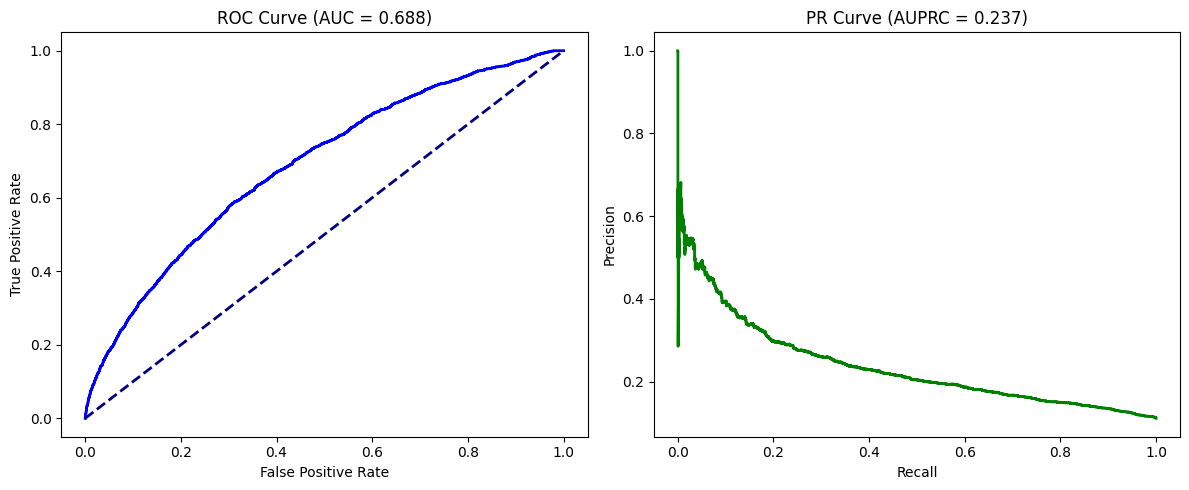

In [21]:
fpr, tpr, _ = roc_curve(y_test, test_cal)
prec, rec, _ = precision_recall_curve(y_test, test_cal)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve (AUC = {:.3f})".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.subplot(1,2,2)
plt.plot(rec, prec, color='green', lw=2)
plt.title("PR Curve (AUPRC = {:.3f})".format(average_precision_score(y_test, test_cal)))
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

## 14. Save Artifacts

> **Readme:**
> This final cell saves the key model 'artifacts': the list of 12 XGBoost models, the calibrator, and the list of feature columns. It then zips these into `ml_artifacts.zip` so you can easily download them from Colab.

In [22]:
joblib.dump(models, f"{SAVE_DIR}/ensemble_xgb.pkl")
joblib.dump(calibrator, f"{SAVE_DIR}/calibrator.pkl")

json.dump(list(X.columns), open(f"{SAVE_DIR}/feature_columns.json","w"), indent=2)

print("All artifacts saved in", SAVE_DIR)

!zip -r /content/ml_artifacts.zip /content/ml_artifacts
print("\nDone! You can download /content/ml_artifacts.zip from the 'Files' panel on the left.")

All artifacts saved in /content/ml_artifacts
updating: content/ml_artifacts/ (stored 0%)
updating: content/ml_artifacts/feature_columns.json (deflated 62%)
updating: content/ml_artifacts/ensemble_xgb.pkl (deflated 71%)
updating: content/ml_artifacts/calibrator.pkl (deflated 38%)

Done! You can download /content/ml_artifacts.zip from the 'Files' panel on the left.
